常用图形操作
#matplotlib

1. 显示图片
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

lena = mpimg.imread('lena.png') # 读取和代码处于同一目录下的 lena.png
#此时 lena 就已经是一个 np.array 了，可以对它进行任意处理
lena.shape #(512, 512, 3)

plt.imshow(lena) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

2. 显示某个通道
#显示图片的第一个通道
lena_1 = lena[:,:,0]
plt.imshow('lena_1')
plt.show()
#此时会发现显示的是热量图，不是我们预想的灰度图，可以添加 cmap 参数，有如下几种添加方法：
plt.imshow('lena_1', cmap='Greys_r')
plt.show()

img = plt.imshow('lena_1')
img.set_cmap('gray') # 'hot' 是热量图
plt.show()

3. 将 RGB 转为灰度图
matplotlib 中没有合适的函数可以将 RGB 图转换为灰度图，可以根据公式自定义一个：
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

gray = rgb2gray(lena)    
#也可以用 plt.imshow(gray, cmap = plt.get_cmap('gray'))
plt.imshow(gray, cmap='Greys_r')
plt.axis('off')
plt.show()

4. 对图像进行放缩
这里要用到 scipy
from scipy import misc
lena_new_sz = misc.imresize(lena, 0.5) # 第二个参数如果是整数，则为百分比，如果是tuple，则为输出图像的尺寸
plt.imshow(lena_new_sz)
plt.axis('off')
plt.show()

二、PIL

1. 显示图片
from PIL import Image
im = Image.open('lena.png')
im.show()

2. 将 PIL Image 图片转换为 numpy 数组
im_array = np.array(im)
#也可以用 np.asarray(im) 区别是 np.array() 是深拷贝，np.asarray() 是浅拷贝

3. 保存 PIL 图片
直接调用 Image 类的 save 方法
from PIL import Image
I = Image.open('lena.png')
I.save('new_lena.png')

4. 将 numpy 数组转换为 PIL 图片
这里采用 matplotlib.image 读入图片数组，注意这里读入的数组是 float32 型的，范围是 0-1，而 PIL.Image 数据是 uinit8 型的，范围是0-255，所以要进行转换：
import matplotlib.image as mpimg
from PIL import Image
lena = mpimg.imread('lena.png') # 这里读入的数据是 float32 型的，范围是0-1
im = Image.fromarray(np.uinit8(lena*255))
im.show()

 5. RGB 转换为灰度图
from PIL import Image
I = Image.open('lena.png')
I.show()
L = I.convert('L')
L.show()

CV2
1.读取
 读入时可制定
cvim=cv2.imread(chosedfile[0],cv2.CV_LOAD_IMAGE_GRAYSCALE)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import mnist
from PIL import Image
import os
import os.path
import random
import cv2
import math
from scipy import ndimage
import torch.utils.data as data

In [2]:
%matplotlib inline
def imshow(img):
    img = img / 2 + 0.5 # unnormalize Inception v3 	22.55 	6.44
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
def getBestShift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)
    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)
    return shiftx,shifty
    
def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted    
  
def centrelize(gray): # move a char, black as background, and white as foreground,  to center of a 28*28 image
    while np.sum(gray[0]) == 0:
        gray = gray[1:]
        
    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray,0,1)

    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]
        
    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray,-1,1)

    rows,cols = gray.shape
        
    if rows>cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
        gray = cv2.resize(gray,(cols,rows))
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
        gray = cv2.resize(gray,(cols,rows))

    colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
    rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
    gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')
    shiftx,shifty = getBestShift(gray)
    shifted = shift(gray,shiftx,shifty)
    
    return shifted    

In [13]:
class PICSET(data.Dataset):
    picroot='pic'
    
    def __getitem__(self,index):
        img=self.dataset[index]
        img=Image.fromarray(img.numpy(), mode='L')
        if self.transform is not None:
            img=self.transform(img)
        return img
    
    def __len__(self):
        return self.len

    def __init__(self,root,transform=None):
        self.picroot=root
        self.transform=transform
        self.kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3, 3))
        
        if not os.path.exists(self.picroot):
            raise RuntimeError('{} doesnot exists'.format(self.picroot))
        for root,dnames,filenames in os.walk(self.picroot):
            imgs=np.ndarray(shape=(len(filenames),28,28),dtype=np.float)
            i=0
            for filename in filenames:
                picfilename=os.path.join(self.picroot,filename)
                im=cv2.imread(picfilename,cv2.IMREAD_GRAYSCALE)
                im=cv2.resize(255-im,(28,28))
                (thresh, im) = cv2.threshold(im, 32, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)   
                #im=cv2.erode(im,self.kernel)
                #im=cv2.dilate(im,self.kernel)
                #im=cv2.GaussianBlur(im,(5,5),0.1)
                im=centrelize(im)
                (thresh, im) = cv2.threshold(im, 32, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)   
                imgs[i]=im/255
                i=i+1
            self.dataset=torch.FloatTensor(imgs)
            self.len=len(filenames)        

In [14]:
class Net1(nn.Module):
    def __init__(self):    
        super(Net1, self).__init__()        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool  = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*4*4, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        self.conv2drop=nn.Dropout2d()
        
    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2drop(self.conv2(x))))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x)
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= sos.path
        return num_features


class Net2(nn.Module):
    def __init__(self):    
        super(Net2, self).__init__()        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)        
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= sos.path
        return num_features

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)    

In [15]:
#model=Net1()
#model.load_state_dict(torch.load('/home/wang/git/cifar10/mnist.weight'))
model=Model()
model.load_state_dict(torch.load('/home/wang/git/cifar10/officalmnist.weight'))

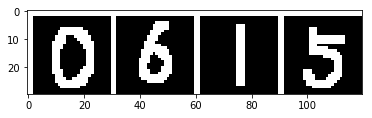

In [28]:
#图像来自pic目录
batch=4
inputarray=np.ndarray(shape=(batch,1,28,28),dtype=float)
files=os.listdir('pic')
chosedfile={}.fromkeys(range(batch))
for k in chosedfile:
    chosedfile[k]=os.path.join('pic',random.choice(files))

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3, 3))
for k in chosedfile:
    im=cv2.imread(chosedfile[k],cv2.CV_LOAD_IMAGE_GRAYSCALE)
    gray=cv2.resize(255-im,(28,28))
    (thresh, gray) = cv2.threshold(gray, 32, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)   
    gray=centrelize(gray)
    (thresh, gray) = cv2.threshold(gray, 32, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)   
    gray=cv2.dilate(gray,kernel)
    gray=gray/255
    gray=(gray-0.5)*2
    inputarray[k][0]=gray

inputs=torch.FloatTensor(inputarray)
imshow(torchvision.utils.make_grid(inputs))    

#---------自行构造从目录读图的dataset以便使用dataloader
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                             ])
#picset = PICSET(root='pic', transform=transform)
#picloader = torch.utils.data.DataLoader(picset, batch_size=batch, shuffle=False, num_workers=1)
#piciter = iter(picloader)


In [29]:
#mages = piciter.next()
#=images.numpy()
#rint a.shape
#rint a[0][0]
#mshow(torchvision.utils.make_grid(torch.FloatTensor(images.numpy()/2+0.5)))

#images = torch.FloatTensor((1-(images.numpy()/2+0.5)-0.5)*2)
       
#imshow(torchvision.utils.make_grid(torch.FloatTensor((1-(images.numpy()/2+0.5)-0.5)*2)))     #from [-1,1] to [0,1] and to[-1,1]   

outputs = model(Variable(inputs))
_,predicted = torch.max(outputs.data, 1)
#print chosedfile
print predicted.int()
#print classes[predicted.int()] 


 0
 6
 1
 5
[torch.IntTensor of size 4x1]



In [30]:
#图像来自mnist test set
#testset = mnist.MNIST(root='MNIST', train=False, download=True)
#b=random.randint(0,mnist.MNIST.__len__(testset)-batch)
#for i in range(0,batch):
    #timg,tlabel=mnist.MNIST.__getitem__(testset,b+i)  #timg is PIL.Image
    #inputarray[i][0]=np.asarray(list(timg.getdata())).reshape((28,28))
    #inputarray[i][0]=inputarray[i][0]/255
    #inputarray[i][0]=(inputarray[i][0]-0.5)*2
#inputs=torch.FloatTensor(inputarray)
#imshow(torchvision.utils.make_grid(inputs))        
#-----------------------------------
testset = mnist.MNIST(root='MNIST', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch, shuffle=False, num_workers=2)
mnistiter = iter(testloader)

Files already downloaded


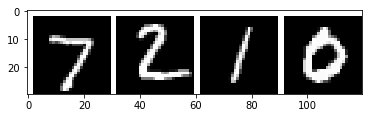

In [31]:
images, labels = mnistiter.next()
imshow(torchvision.utils.make_grid(images))        

In [32]:
outputs = model(Variable(images))
_,predicted = torch.max(outputs.data, 1)
print predicted.int()



 7
 2
 1
 0
[torch.IntTensor of size 4x1]

